## **Classification of Traffic signs using Custom CNN**

---

The goal is here to classify the German Traffic signs into 43 different classes. The project is carried out using python and tensorflow.

In [1]:
#Import necessary libraries

from google.colab import drive
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from imgaug import augmenters  as iaa
import cv2
import random

In [2]:
drive.mount('/content/drive')

!ls '/content/drive/My Drive/Classification_traffic'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
classifier2.h5	CNN.h5	   Saved_Models  traffic.h5
Classifier.h5	model.png  traffic_2.h5  traffic-signs-data


In [3]:
import pickle

%cd  '/content/drive/My Drive/Classification_traffic'

train = "traffic-signs-data/train.p"
validation = "traffic-signs-data/valid.p"
test = "traffic-signs-data/test.p"

with open(train, mode='rb') as f:
    train = pickle.load(f)
with open(validation, mode='rb') as f:
    valid = pickle.load(f)
with open(test, mode='rb') as f:
    test = pickle.load(f)

/content/drive/My Drive/Classification_traffic


In [4]:
signs = ["Speed limit (20km/h)","Speed limit (30km/h)","Speed limit (50km/h)","Speed limit (60km/h)","Speed limit (70km/h)","Speed limit (80km/h)","End of speed limit (80km/h)","Speed limit (100km/h)","Speed limit (120km/h)","No passing","No passing for vehicles over 3.5 metric tons","Right-of-way at the next intersection","Priority road","Yield","Stop","No vehicles","Vehicles over 3.5 metric tons prohibited","No entry","General caution","Dangerous curve to the left","Dangerous curve to the right","Double curve","Bumpy road","Slippery road","Road narrows on the right","Road work","Traffic signals","Pedestrians","Children crossing","Bicycles crossing","Beware of ice/snow","Wild animals crossing","End of all speed and passing limits","Turn right ahead","Turn left ahead","Ahead only","Go straight or right","Go straight or left","Keep right","Keep left","Roundabout mandatory","End of no passing","End of no passing by vehicles over 3.5 metric tons"]
len(signs)

43

In [5]:
#Dataset is created such that the first element of the pillowed data consist of features (representing the image) and the second element is its label
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Number of images in the dataset for Training",len(X_train))
print("Number of images in the dataset for Validation",len(X_valid))
print("Number of images in the dataset for Testing", len(X_test))
print("Size of the image", X_train[0].shape)

#The image are resized to 32x32

Number of images in the dataset for Training 34799
Number of images in the dataset for Validation 4410
Number of images in the dataset for Testing 12630
Size of the image (32, 32, 3)




---

### **Dataset overview and visualisation**

View some of the train, test and validate images

In [6]:
import matplotlib.pyplot as plt
import random

def view_images(images, label, title, cma = None):
  plt.figure(figsize=(10, 10))
  for i in range(4):
    plt.subplot(1, 4, i+1)
    if cma is not None:
      plt.imshow(images[i], cmap = cma)
    else:
      plt.imshow(images[i])
    plt.xlabel(label[i])
    plt.ylabel(" ")
    plt.xticks([])
    plt.yticks([])
    if i == 1:
      plt.title(title, loc='left')
  plt.show()
  print("-------------------------------------------------------------------------------\n")

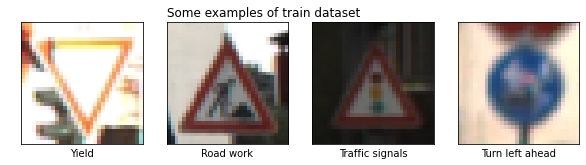

-------------------------------------------------------------------------------



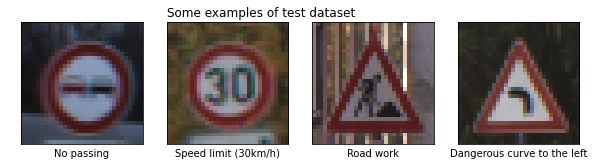

-------------------------------------------------------------------------------



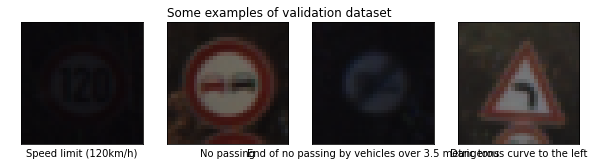

-------------------------------------------------------------------------------



In [7]:
X_train_random = []
y_train_random = []
for i in range(4):
  index = random.randint(0, len(X_train))
  X_train_random.append(X_train[index])
  y_train_random.append(signs[y_train[index]])

title = "Some examples of train dataset"
view_images(X_train_random, y_train_random, title)

X_test_random = []
y_test_random = []
for i in range(4):
  index = random.randint(0, len(X_test))
  X_test_random.append(X_test[index])
  y_test_random.append(signs[y_test[index]])

title = "Some examples of test dataset"
view_images(X_test_random, y_test_random, title)

X_valid_random = []
y_valid_random = []
for i in range(4):
  index = random.randint(0, len(X_valid))
  X_valid_random.append(X_valid[index])
  y_valid_random.append(signs[y_valid[index]])

title = "Some examples of validation dataset"
view_images(X_valid_random, y_valid_random, title)

- View one image from each class 
- Get number of images in each class
- Perform a histogram plot to understand the image distribution in each class

In [8]:
sign, indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)

Class 0: Speed limit (20km/h)                               180 samples
Class 1: Speed limit (30km/h)                               1980 samples
Class 2: Speed limit (50km/h)                               2010 samples
Class 3: Speed limit (60km/h)                               1260 samples
Class 4: Speed limit (70km/h)                               1770 samples
Class 5: Speed limit (80km/h)                               1650 samples
Class 6: End of speed limit (80km/h)                        360 samples
Class 7: Speed limit (100km/h)                              1290 samples
Class 8: Speed limit (120km/h)                              1260 samples
Class 9: No passing                                         1320 samples
Class 10: No passing for vehicles over 3.5 metric tons       1800 samples
Class 11: Right-of-way at the next intersection              1170 samples
Class 12: Priority road                                      1890 samples
Class 13: Yield                                   

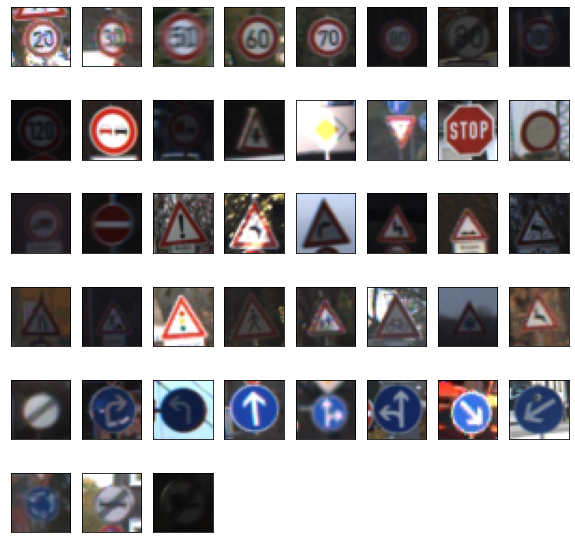

In [9]:
word_width = max(len(name) for name in signs)
plt.figure(figsize=(10, 10))
for i in range(len(signs)):
  print("Class %i: %-*s %s samples" % (i, word_width, signs[i], str(class_counts[i])))
  random_index = random.sample(range(indices[i], indices[i] + class_counts[i]), 1)
  plt.subplot(6, 8, i+1)
  plt.imshow(X_train[random_index[0]])
  plt.xticks([])
  plt.yticks([])
plt.show()

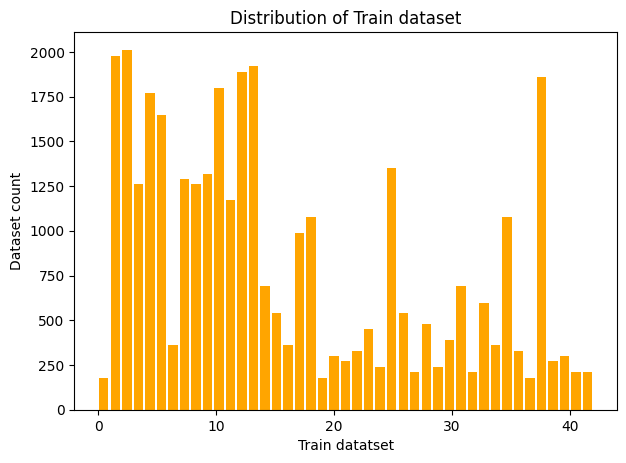

In [10]:
hist, bins = np.histogram(y_train, bins=43)
center = (bins[:-1] + bins[1:]) / 2
plt.subplots(figsize=(7,5), dpi=100)
plt.bar(center, hist, color="orange")
plt.xlabel("Train datatset")
plt.ylabel("Dataset count")
plt.title("Distribution of Train dataset")
plt.show()

It is quite clear from the histogram plot that the dataset distribution among 43 classes are not uniform. The classes like Speed limit (20km/h), Go straight or left are very low while classes like No passing for vehicles over 3.5 metric tons, Keep right are relly high (about 10x). This will lead to a biased prediction when trained in any model and then Dataset equivalisation and augumentation process has to be performed to get better results.

---

### **Data Preprocessing**

- One-hot encoding of dataset labels, since the labels are categorical data.
- Shuffling to improve the randomness before training (it is only applied to training dataset).

In [11]:
def one_hot_encoding(labels, classes_num):
  matrix = np.eye(classes_num)
  res_labels = []
  for i in range(len(labels)):
    res_labels.append(matrix[:,labels[i]])
  result = np.array(res_labels)
  return result

In [12]:
from sklearn.utils import shuffle
def shuff(X,y):
  X,y = shuffle(X,y)
  return X,y

---

### **Data Augumentation**

- There are several different types of data augumentatin techniques that can be performed to improve the distribution balance.
- Initially, all the classes that have datasets lesser than 1000 are found.
- Its been come notice that some class datasets can be increased by performing flipping or rotation of the image.
- Classes like Dangerous curve to the left, Turn left ahead, Go straight or left can be flipped right once and fall under classes like Dangerous curve to the right, Turn right ahead, Go straight or right and vice versa. This will help improve the population in each others classes.
- Classes like End of all speed and passing limits can be flipped right once and down once.
- Classes whose datasets that can not be improved by the above methods can then be improved by random brightness, cropping, zoom or pan.

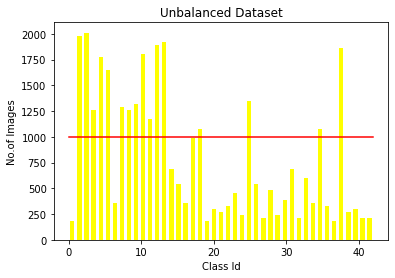

In [13]:
num_bins = 43
samples_per_bin = 1000
plt.hist(y_train, bins =num_bins,rwidth=0.6, color = "yellow")
plt.plot((np.min(y_train), np.max(y_train)), (samples_per_bin, samples_per_bin), color = "red")
plt.title('Unbalanced Dataset')
plt.xlabel('Class Id')
plt.ylabel('No.of Images')
plt.show()

In [14]:
word_width = max(len(name) for name in signs)
count = 0
for i in range(len(signs)):
  if(class_counts[i] < 1000):
    count += 1
    print("Class %i: %-*s %s samples" % (i, word_width, signs[i], str(class_counts[i])))

print("Number of classes that has count lesser than 1000 is : ",count)

Class 0: Speed limit (20km/h)                               180 samples
Class 6: End of speed limit (80km/h)                        360 samples
Class 14: Stop                                               690 samples
Class 15: No vehicles                                        540 samples
Class 16: Vehicles over 3.5 metric tons prohibited           360 samples
Class 17: No entry                                           990 samples
Class 19: Dangerous curve to the left                        180 samples
Class 20: Dangerous curve to the right                       300 samples
Class 21: Double curve                                       270 samples
Class 22: Bumpy road                                         330 samples
Class 23: Slippery road                                      450 samples
Class 24: Road narrows on the right                          240 samples
Class 26: Traffic signals                                    540 samples
Class 27: Pedestrians                                

In [15]:
from PIL import Image

def flip_left(image):
  image = Image.fromarray(image)
  return np.array(image.transpose(Image.FLIP_LEFT_RIGHT))

def flip_left_down(image):
  image = Image.fromarray(image)
  image = image.transpose(Image.FLIP_LEFT_RIGHT)
  return np.array(image.transpose(Image.FLIP_TOP_BOTTOM))

def rotate(image):
  image = Image.fromarray(image)
  return np.array(image.rotate(90))

def rotate_20(image):
  image = Image.fromarray(image)
  return np.array(image.rotate(20))

def zoom(image):
  zoommed = iaa.Affine(scale = (0.9, 1.3))
  return zoommed.augment_image(image)

def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  return pan.augment_image(image)

def brightness(image):
  contrast=iaa.GammaContrast(gamma=2.0)
  return contrast.augment_image(image)

def crop(image):
  crop = iaa.Crop(percent=(0, 0.3)) # crop image
  return crop.augment_image(image)



In [16]:
flipped_left = []
FL_label = []
flipped_left_down = []
FLD_label = []

#Class 32 can be flipped left and then down + zoom and can be added to the same class
for j,label in enumerate(y_train):
  if label == 32:
    img = X_train[j]
    img = flip_left_down(img)
    flipped_left_down.append(zoom(img))
    FLD_label.append(label)

#Class 40 - flipped and rotated + zoom
for j,label in enumerate(y_train):
  if label == 40:
    img = X_train[j]
    img = flip_left(img)
    img = rotate(img)
    flipped_left.append(zoom(img))
    FL_label.append(label)

#Class 19 can be flipped and added to 20 , viceversa
#Class 33 can be flipped and added to 34 , viceversa
#Class 36 can be flipped and added to 37 , viceversa
for j,label in enumerate(y_train):
  if label == 19:
    img = X_train[j]
    img = flip_left(img)
    flipped_left.append(zoom(img))
    FL_label.append(20)

  if label == 20:
    img = X_train[j]
    img = flip_left(img)
    flipped_left.append(pan(img))
    FL_label.append(19)

  if label == 33:
    img = X_train[j]
    img = flip_left(img)
    flipped_left.append(zoom(img))
    FL_label.append(34)

  if label == 34:
    img = X_train[j]
    img = flip_left(img)
    flipped_left.append(pan(img))
    FL_label.append(33)
  
  if label == 36:
    img = X_train[j]
    img = flip_left(img)
    flipped_left.append(zoom(img))
    FL_label.append(37)

  if label == 37:
    img = X_train[j]
    img = flip_left(img)
    flipped_left.append(pan(img))
    FL_label.append(36)

# All the classes are randomly applied with zoom, pan, brightness and crop

Zoomed = []
Zoomed_label = []
for i in range(len(y_train)):
  j = i
  img = X_train[j]
  label = y_train[j]
  Zoomed.append(zoom(img))
  Zoomed_label.append(label)

Pan = []
Pan_label = []
for i in range(len(y_train)):
  j = i
  img = X_train[j]
  label = y_train[j]
  Pan.append(pan(img))
  Pan_label.append(label)

Bright = []
Bright_label = []
random_index = random.sample(range(len(y_train)),int(len(y_train)/2))
for i in range(int(len(y_train)/2)):
  j = random_index[i]
  img = X_train[j]
  label = y_train[j]
  Bright.append(brightness(img))
  Bright_label.append(label)

Cropped = []
Cropped_label = []
random_index = random.sample(range(len(y_train)),int(len(y_train)/2))

for i in range(int(len(y_train)/2)):
  j = random_index[i]
  img = X_train[j]
  label = y_train[j]
  Cropped.append(crop(img))
  Cropped_label.append(label)

In [17]:
flipped_left = np.array(flipped_left)
flipped_left_down = np.array(flipped_left_down)
Zoomed = np.array(Zoomed)
Pan = np.array(Pan)
Bright = np.array(Bright)
Cropped = np.array(Cropped)
A_X_train = np.array(X_train)
A_X_train = np.concatenate((A_X_train, flipped_left, flipped_left_down, Zoomed, Pan, Bright, Cropped))

FL_label = np.array(FL_label)
FLD_label = np.array(FLD_label)
Zoomed_label = np.array(Zoomed_label)
Pan_label = np.array(Pan_label)
Bright_label = np.array(Bright_label)
Cropped_label = np.array(Cropped_label)
A_y_train = np.array(y_train)
A_y_train = np.concatenate((A_y_train, FL_label, FLD_label, Zoomed_label, Pan_label, Bright_label, Cropped_label))

In [18]:
remove_list = []
for j in range(43):
  l = []
  for i in range(len(A_y_train)):
    if A_y_train[i]>= bins[j] and A_y_train[i]<=bins[j+1]:
      l.append(i)
  l = shuffle(l)
  
  if len(l)>1000:
    l = l[1000:]
    remove_list.extend(l)

print('removed:', len(remove_list)) 

A_X_train = np.delete(A_X_train, remove_list, axis=0)
print ('remaining images:', len(A_X_train))

A_y_train = np.delete(A_y_train, remove_list, axis=0)
print ('remaining labels:', len (A_y_train))

removed: 99488
remaining images: 42166
remaining labels: 42166


In [19]:
print("Number of dataset after augumentation process: ",A_y_train.shape[0])

Number of dataset after augumentation process:  42166



---

Preparation of dataset to train

In [20]:
P_X_train, P_y_train = shuff(A_X_train, A_y_train)

#One hot encoding labels
P_y_train = one_hot_encoding(P_y_train, 43)
P_y_valid = one_hot_encoding(y_valid, 43)

print(P_X_train.shape, P_y_train.shape)

(42166, 32, 32, 3) (42166, 43)


---

### **Build the model**

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model

In [22]:
def CNN():
  model = Sequential()

  #Layer - 1 : Convolutionals layer with 24 kernals
  model.add(Conv2D(24, kernel_size=(5,5), strides=(1,1), input_shape=(32, 32, 3), activation='relu'))
  #Layer - 2 : Convolutionals layer
  model.add(Conv2D(36, kernel_size=(5,5), strides=(1,1), activation='relu'))
  #Layer - 3 : Convolutionals layer
  model.add(Conv2D(48, kernel_size=(3,3), strides=(1,1), activation='relu'))
  #Layer - 4 : Convolutionals layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  #Layer - 5 : Convolutionals layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  #Layer - 6 : Dense Layer
  model.add(Flatten())
  model.add(Dense(250, activation='relu'))
  #Layer - 7 : Dense Layer
  model.add(Dense(125, activation='relu'))
  #Layer - 8 : Dense Layer
  model.add(Dense(75, activation='relu'))

  #Output layer
  model.add(Dense(43, activation='softmax'))
  
  #Compile model
  model.compile(Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [23]:
model = CNN()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 48)        15600     
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 64)        27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 20736)             0         
                                                                 
 dense (Dense)               (None, 250)               5

---

### **Training CNN and evaluation**

In [24]:
print("================================================================================================================================")
print("                                               Training the neural network")
history = model.fit(x=P_X_train, y=P_y_train, 
                    batch_size=32, 
                    epochs=12, 
                    verbose=1, 
                    validation_data=(X_valid, P_y_valid), 
                    shuffle=True)

                                               Training the neural network
Epoch 1/12
1318/1318 [==============================] - 13s 8ms/step - loss: 1.4489 - accuracy: 0.6620 - val_loss: 0.4214 - val_accuracy: 0.9050
Epoch 2/12
1318/1318 [==============================] - 10s 7ms/step - loss: 0.4671 - accuracy: 0.8920 - val_loss: 0.2454 - val_accuracy: 0.9469
Epoch 3/12
1318/1318 [==============================] - 10s 7ms/step - loss: 0.2359 - accuracy: 0.9433 - val_loss: 0.2218 - val_accuracy: 0.9508
Epoch 4/12
1318/1318 [==============================] - 10s 7ms/step - loss: 0.1472 - accuracy: 0.9621 - val_loss: 0.1538 - val_accuracy: 0.9612
Epoch 5/12
1318/1318 [==============================] - 10s 7ms/step - loss: 0.1007 - accuracy: 0.9742 - val_loss: 0.1871 - val_accuracy: 0.9635
Epoch 6/12
1318/1318 [==============================] - 10s 7ms/step - loss: 0.0745 - accuracy: 0.9797 - val_loss: 0.3666 - val_accuracy: 0.9256
Epoch 7/12
1318/1318 [==============================] -

In [25]:
print("================================================================================================================================")
print("                                               Evaluate the neural network")

P_y_test = one_hot_encoding(y_test, 43)
results = model.evaluate(X_test, P_y_test)
print("test loss, test acc:", results)

                                               Evaluate the neural network
395/395 [==============================] - 2s 4ms/step - loss: 0.3386 - accuracy: 0.9474
test loss, test acc: [0.33857131004333496, 0.9474267363548279]


In [26]:
model.save("classifier2.h5")

---

### **Testing the model with new datasets**

/content
Prediction:  No passing


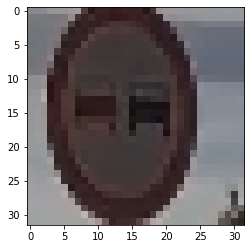

Prediction:  Speed limit (30km/h)


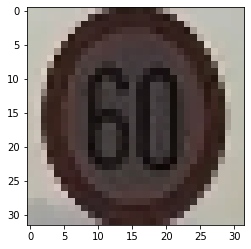

Prediction:  Speed limit (30km/h)


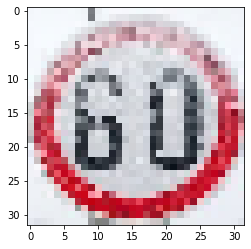

Prediction:  Yield


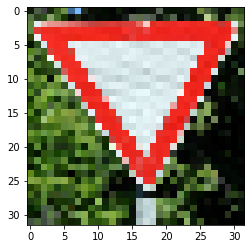

Prediction:  Speed limit (60km/h)


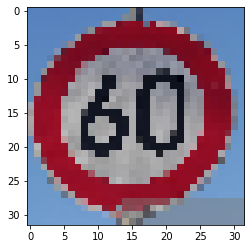

Prediction:  Stop


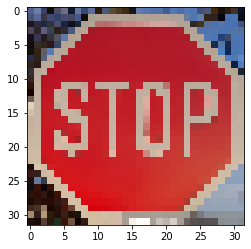

Prediction:  Pedestrians


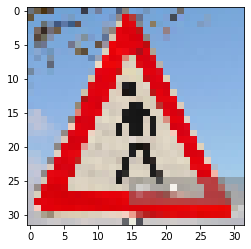

Prediction:  No entry


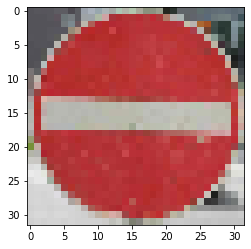

In [27]:
%cd "/content"
ig = []

ig.append(cv2.imread("234.png"))
ig.append(cv2.imread("123.png"))
ig.append(cv2.imread("345.jpg"))
ig.append(cv2.imread("001.jpg"))
ig.append(cv2.imread("002.jpg"))
ig.append(cv2.imread("003.jpg"))
ig.append(cv2.imread("004.jpg"))
ig.append(cv2.imread("005.jpg"))

img = []
for i in ig:
  i = cv2.resize(i,(32,32))
  i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
  img.append(i)
img = np.array(img)

for i in img:
  plt.imshow(i)
  crop_img =  i.reshape(-1, 32,32,3)
  print ("Prediction: ", signs[np.argmax(model.predict(crop_img))])
  plt.show()